# 3. Symulacja numeryczna - schemat niejawny

Celem symulacji jest rozwiązanie problemu początkowo-brzegowego zdefiniowanego przez układ równań (4)-(7).

**Równania ewolucji (4)-(5):**
$$
\begin{cases}
\frac{\partial u}{\partial t} = a - u - uv^2 + d_1 \Delta u \\
\frac{\partial v}{\partial t} = uv^2 - mv + d_2 \Delta v
\end{cases}
$$

**Warunki Brzegowe (6):**
$$
u(x, t) = v(x, t) = 0 \tag{6}
$$

**Warunki Początkowe (7):**
Symulację startujemy od stanu pustynnego z nałożonym małym losowym zaburzeniem (szumem) $\xi$:
$$
u(x, y, 0) = a, \quad v(x, y, 0) = \xi(x, y) \tag{7}
$$

### Metoda numeryczna i dyskretyzacja

Przestrzeń dyskretyzujemy metodą różnic skończonych na siatce $N \times N$. Operator Laplace'a $\Delta$ aproksymujemy standardowym schematem pięciopunktowym.

Stosujemy schemat niejawny z rozdzieleniem operatorów.

W każdym kroku czasowym $h_t$ obliczenia dzielimy na etapy:

1.  **Krok Reakcji (Nieliniowy):** Obliczamy zmianę wynikającą z lokalnej dynamiki $f(u, v)$ metodą jawną:
    $$u^* = u^n + h_t \cdot f(u^n, v^n)$$

2.  **Krok Dyfuzji:** Operator Laplace'a $\Delta$ rozbijamy na kierunki $X$ i $Y$. Zamiast rozwiązywać jedną dużą macierz $N^2 \times N^2$, rozwiązujemy naprzemiennie układy równań dla wierszy i kolumn:

    * Rozwiązujemy dyfuzję wzdłuż osi $x$.
        $$(I - \frac{h_t}{2} D \partial_{xx}) u^{**} = u^* + \frac{h_t}{2} D \partial_{yy} u^*$$
    * Rozwiązujemy dyfuzję wzdłuż osi $y$.
        $$(I - \frac{h_t}{2} D \partial_{yy}) u^{n+1} = u^{**} + \frac{h_t}{2} D \partial_{xx} u^{**}$$

Powyższe podejście sprowadza problem 2D do serii układów z macierzami trójdiagonalnymi, które rozwiązujemy za pomocą Algorytmu Thomasa.

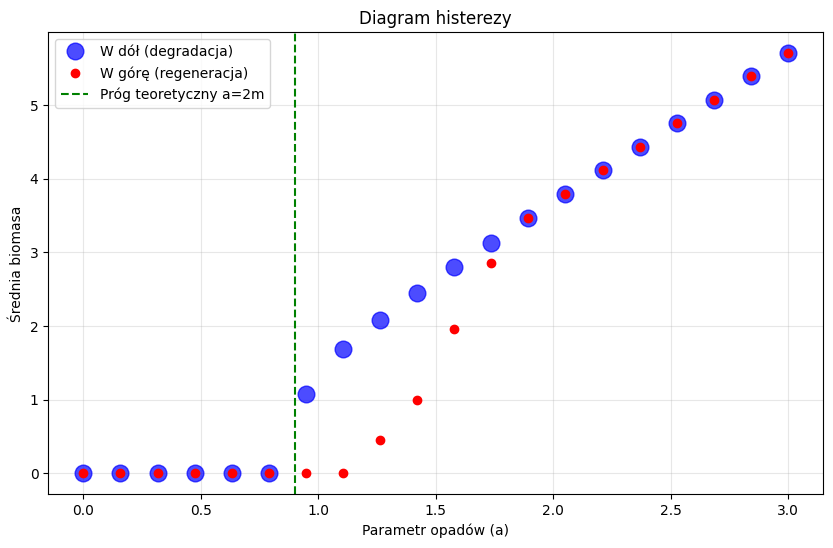

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

from pipeline.parameters import KlausmeierParameters
from pipeline.solver import KlausmeierSolver

# symulacja
N = 32            # siatka
T = 100
DT = 0.01         # krok
k = int(T / DT)   # liczba krokow
pkt_a = 20        # punkty dla a

# pobranie parametrów bezwymiarowych
params_obj = KlausmeierParameters(A=2.0, L=1.0, R=0.5, J=1.0, M=0.45, Dw=0.1, Dn=0.01)
p = params_obj.get_dimensionless_params()

start_time = time.time()

a_down = np.linspace(3.0, 0.0, pkt_a)
a_up   = np.linspace(0.0, 3.0, pkt_a)
full_path = np.concatenate([a_down, a_up])

results = []

solver = KlausmeierSolver(N, DT, p)
solver.a = full_path[0]
solver.U[:] = solver.a
solver.V[:] = 5.0

for i, a_val in enumerate(full_path):
    solver.a = a_val
    
    # powrót i nasiona
    if i >= pkt_a:
        if np.mean(solver.V) < 0.1:
            solver.V += np.random.uniform(0, 0.5, (N, N))

    for _ in range(k):
        solver.solve_step()
        
    results.append(np.mean(solver.V))

# rozdzielenie wyników do wykresu
results_down = results[:pkt_a]
results_up = results[pkt_a:]

plt.figure(figsize=(10, 6))
plt.plot(a_down, results_down, 'bo', markersize=12, alpha=0.7, label='W dół (degradacja)')
plt.plot(a_up, results_up, 'ro', markersize=6, label='W górę (regeneracja)')

plt.axvline(x=0.9, color='green', linestyle='--', label='Próg teoretyczny a=2m')
plt.title('Diagram histerezy')
plt.xlabel('Parametr opadów (a)')
plt.ylabel('Średnia biomasa')
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig('../diagram_histerezy.png', dpi=300, bbox_inches='tight')
plt.show()

header = "opady_a,biomasa_srednia"

data_down = np.column_stack((a_down, results_down))
np.savetxt('../wyniki_degradacja.csv', data_down, delimiter=',', header=header, comments='')

data_up = np.column_stack((a_up, results_up))
np.savetxt('../wyniki_regeneracja.csv', data_up, delimiter=',', header=header, comments='')

**Diagram bifurkacyjny modelu Klausmeiera.**
Wykres przedstawia zależność średniej biomasy roślin ($v$) od parametru opadów ($a$). 
Kolorem niebieskim oznaczamy proces degradacji (start z pełnego zalesienia), gdzie nagłe załamanie ekosystemu następuje w okolicy progu teoretycznego $a \approx 0.9$. 
Kolorem czerwonym oznaczamy proces regeneracji (start z pustyni). Widoczna pętla histerezy wskazuje na zjawisko bistabilności – w zakresie $a \in (0.9, 1.4)$ możliwe jest współistnienie zarówno stanu wegetacji, jak i stanu pustynnego, zależnie od historii układu.

Obliczamy rozwiązanie referencyjne dla dt = 0.005
Testujemy większe kroki czasowe:
   dt = 0.200 -> Błąd = 5.925571
   dt = 0.100 -> Błąd = 0.000006
   dt = 0.050 -> Błąd = 0.000002
   dt = 0.020 -> Błąd = 0.000001
   dt = 0.010 -> Błąd = 0.000000


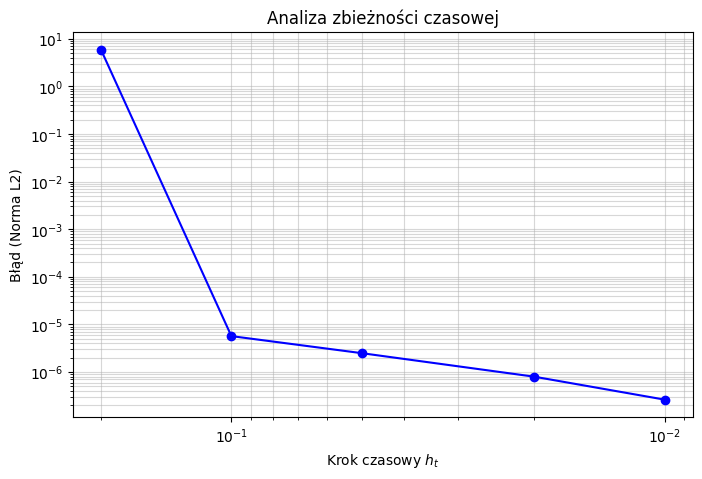

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

from pipeline.solver import KlausmeierSolver

N_TEST = 32      
T_TEST = 10.0
SEEDS = 42

dt_values = [0.2, 0.1, 0.05, 0.02, 0.01] 
dt_ref = 0.005 

p_test = {'a': 2.0, 'm': 0.45, 'd1': 0.1, 'd2': 0.01}

def run_simulation(N, dt, T, seed, params):
    """Pomocnicza funkcja do uruchomienia symulacji o zadanych parametrach"""
    steps = int(T / dt)
    solver = KlausmeierSolver(N, dt, params) # Używamy Twojej klasy z pipeline
    
    np.random.seed(seed)
    # u(x, y, 0) = a + szum, v(x, y, 0) = 2.0 + szum [cite: 119]
    solver.U = np.full((N, N), params['a']) + np.random.uniform(-0.1, 0.1, (N, N))
    solver.V = np.full((N, N), 2.0) + np.random.uniform(-0.1, 0.1, (N, N))
    
    for _ in range(steps):
        solver.solve_step()
    return solver.V

print("Obliczamy rozwiązanie referencyjne dla dt =", dt_ref)
v_ref = run_simulation(N_TEST, dt_ref, T_TEST, SEEDS, p_test)

errors = []
print("Testujemy większe kroki czasowe:")
for dt in dt_values:
    v_test = run_simulation(N_TEST, dt, T_TEST, SEEDS, p_test)
    
    # obliczamy błąd (Norma L2 różnicy macierzy) 
    # dzielimy przez N*N, żeby mieć średni błąd
    err = np.linalg.norm(v_test - v_ref) / (N_TEST * N_TEST)
    errors.append(err)
    print(f"   dt = {dt:.3f} -> Błąd = {err:.6f}")

plt.figure(figsize=(8, 5))
plt.plot(dt_values, errors, 'bo-', label='Błąd względem dt=0.005')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Krok czasowy $h_t$')
plt.ylabel('Błąd (Norma L2)')
plt.title('Analiza zbieżności czasowej')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.gca().invert_xaxis()
plt.savefig('../analiza_zbieznosci.png', dpi=300, bbox_inches='tight')
plt.show()

**Analiza zbieżności czasowej metody numerycznej.**
Wykres przedstawia błąd globalny rozwiązania w funkcji kroku czasowego $h_t$. Jako rozwiązanie referencyjne przyjmujemy symulację z krokiem $dt_{ref} = 0.005$.
Liniowy charakter spadku błędu na skali logarytmicznej (dla $dt \le 0.1$) potwierdza poprawność implementacji algorytmu oraz jego zbieżność. Gwałtowny wzrost błędu dla $dt=0.2$ wyznacza granicę stabilności numerycznej dla nieliniowego członu reakcji.